# Autonomous Perception Robustness Testing Framework (APRTF)
### Development Journal

We show that our general framework can be used on the [NuScenes](https://www.nuscenes.org/) dataset using a multi-stage analysis proposed in ["Perception robustness testing at different levels of generality"](https://www.journalfieldrobotics.org/FR/Papers_files/10_Pezzementi.pdf).

In [1]:
import os

import numpy as np
np.random.seed(42)

from PIL import Image

import matplotlib.pyplot as plt

from nuscenes.utils.geometry_utils import view_points
from nuscenes import NuScenes
data_dir = './data/sets/nuscenes'
nusc = NuScenes(version='v1.0-mini', dataroot=data_dir, verbose=True)

# APRTF
from aprtf.analysis import Analyzer

print("All packages imported!")

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.496 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
All packages imported!


## I. Pedestrian Detection

### Data and Labels

Time-ordered iterator of images and bounding boxes.

In [2]:
def box2bb(box, cam_intrinsic):
    corners = view_points(box.corners(), view=cam_intrinsic, normalize=True)[:2, :]
    bb = np.array([np.min(corners, axis=1), np.max(corners, axis=1)])
    return bb

def bb2rect(bb):
    xmin, ymin = bb[0]
    xmax, ymax = bb[1]
    corners = np.array([[xmin, ymin], 
                        [xmin, ymax],
                        [xmax, ymax],
                        [xmax, ymin]])
    return corners

def draw_rect(axis, selected_corners, color):
    prev = selected_corners[-1]
    for corner in selected_corners:
        axis.plot([prev[0], corner[0]], [prev[1], corner[1]], color=color, linewidth=1)
        prev = corner

def render_annotations(axis, scene_data_fp, scene_data_bb):
    im = Image.open(scene_data_fp)
    axis.imshow(im)
    axis.axis('off')
    axis.set_aspect('equal')
    for bb in scene_data_bb:
        colors = ['b'] * 3
        corners = bb2rect(bb)
        draw_rect(axis, corners, colors[0])

def render_results(axis, scene_data_fp, scene_data_bb, scene_data_pred):
    im = Image.open(scene_data_fp)
    axis.imshow(im)
    axis.axis('off')
    axis.set_aspect('equal')
    
    for bb in scene_data_bb:
        colors = ['b'] * 3
        corners = bb2rect(bb)
        draw_rect(axis, corners, colors[0])
        
    for bb in scene_data_pred:
        colors = ['orange'] * 3
        corners = bb2rect(bb)
        draw_rect(axis, corners, colors[0])

In [3]:
category = 'pedestrian'
sensor = 'CAM_FRONT'
scene = nusc.scene[0]

scene_data_fps = []
scene_data_anns = []
scene_data_bbs = []

next_sample_token = scene['first_sample_token']
while next_sample_token:
    sample = nusc.get('sample', next_sample_token)
    sample_data = nusc.get('sample_data', sample['data'][sensor])

    # image filepaths
    sample_data_fp = os.path.join(data_dir,sample_data['filename'])
    scene_data_fps.append(sample_data_fp)

    # bounding boxes
    sample_data_bbs = []
    sample_data_anns = []
    for ann in sample['anns']:
        _, box, cam_intrinsic = nusc.get_sample_data(sample['data'][sensor], selected_anntokens=[ann])
        if len(box) > 1:
            raise ValueError('more than one annotation')
        elif (len(box) == 1) and (category in box[0].name):
            bb = box2bb(box[0], cam_intrinsic)
            sample_data_bbs.append(bb)
            sample_data_anns.append(ann)
    scene_data_bbs.append(sample_data_bbs)
    scene_data_anns.append(sample_data_anns)
    
    next_sample_token = sample['next']

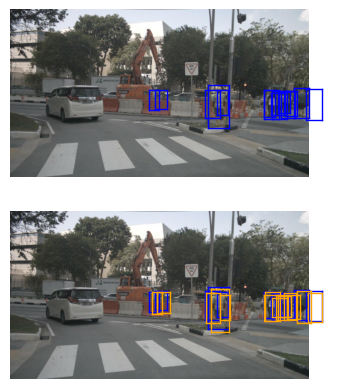

In [6]:
idx = 15
fake_results = np.array(scene_data_bbs[idx]) + 20*np.random.rand(*np.shape(scene_data_bbs[idx]))

# simple testing
fig, (ax1, ax2) = plt.subplots(2,1)

render_annotations(ax1, scene_data_fps[idx], scene_data_bbs[idx])
render_results(ax2, scene_data_fps[idx], scene_data_bbs[idx], fake_results)

### Augmentations

Composition of 

In [5]:
sample_file = os.path.join(data_dir,sample_data_fp)

### Model

Takes in batch or single image, and outputs pedestrian bounding boxes.

### Metric

Recall and $FPR_A$.

In [4]:
def recall():
    pass

def FPRa():
    pass